## Graph Dynamical Systems

This notebooks contains the experiments to evaluate graph edit networks on simple graph dynamical systems, namely the edit cycles, degree rules, and game of life datasets.

### Hyperparameter setup

In [5]:
import time
import numpy as np
import torch
import pytorch_graph_edit_networks as gen
from torch_geometric.utils import dense_to_sparse
import baseline_models
import os
import time
import hep_th

# model hyperparameters
num_layers = 2
dim_hid = 64

# training hyperparameters
learning_rate  = 1E-3
weight_decay   = 1E-5
loss_threshold = 1E-3
max_epochs     = 50000
print_step     = 1000

R = 5        # number of repetitions for each experiment
N_test = 10  # number of test time series we use to evaluate learning afterwards

## Model setup

In [ ]:
# SETUP FUNCTIONS
def setup_vgae(dim_in, nonlin):
    return baseline_models.VGAE(num_layers=num_layers,
                                dim_in=dim_in,
                                dim_hid=dim_hid,
                                beta=1E-3,
                                sigma_scaling=1E-3,
                                nonlin=nonlin)


def setup_vgrnn(dim_in, nonlin):
    return baseline_models.VGRNN(num_layers=num_layers,
                                 dim_in=dim_in,
                                 dim_hid=dim_hid)


def setup_gen(dim_in, nonlin):
    return gen.GEN(num_layers=num_layers,
                   dim_in=dim_in,
                   dim_hid=dim_hid,
                   nonlin=nonlin)

In [ ]:
# LOSS FUNCTIONS
loss_fun = gen.GEN_loss()
crossent_loss_fun = gen.GEN_loss_crossent()
def vgae_loss(model, A, X, delta, Epsilon, state=None):
    B = A + Epsilon
    # delete all outgoing and incoming edges of deleted nodes
    B[delta < -0.5, :] = 0
    B[:, delta < -0.5] = 0
    loss = model.compute_loss(torch.tensor(A, dtype=torch.float),
                              torch.tensor(B, dtype=torch.float),
                              torch.tensor(X, dtype=torch.float))

    return loss, state


def vgrnn_loss(model, A, X, delta, Epsilon, state=None):
    A = torch.tensor(A, dtype=torch.float)
    edge_index = dense_to_sparse(A)

    predicted = model(X, edge_index, hidden_in=state)
    predicted, state = predicted[:-1], predicted[-1]

    target = A + Epsilon
    target[delta < -0.5, :] = 0
    target[:, delta < -0.5] = 0

    return model.compute_loss(*predicted, target), state


def gen_loss_crossent(model, A, X, delta, Epsilon, state=None):
    delta_pred, Epsilon_pred = model(torch.tensor(A, dtype=torch.float),
                                     torch.tensor(X, dtype=torch.float))
    loss = crossent_loss_fun(delta_pred, Epsilon_pred,
                             torch.tensor(delta, dtype=torch.float),
                             torch.tensor(Epsilon, dtype=torch.float),
                             torch.tensor(A, dtype=torch.float))

    return loss, state


def gen_loss(model, A, X, delta, Epsilon, state=None):
    delta_pred, Epsilon_pred = model(torch.tensor(A, dtype=torch.float),
                                     torch.tensor(X, dtype=torch.float))
    loss = loss_fun(delta_pred, Epsilon_pred,
                    torch.tensor(delta, dtype=torch.float),
                    torch.tensor(Epsilon, dtype=torch.float),
                    torch.tensor(A, dtype=torch.float))

    return loss, state

In [ ]:
# PREDICTION FUNCTIONS
def vgae_pred(model, A, X, state=None):
    B = model(torch.tensor(A, dtype=torch.float), torch.tensor(X, dtype=torch.float))
    B = B.detach().numpy()
    Epsilon = B - A
    delta = np.zeros(A.shape[0])
    delta[np.sum(B, 1) < 0.5] = -1.
    Epsilon[delta < -0.5, :] = 0.
    Epsilon[:, delta < -0.5] = 0.
    return delta, Epsilon, state


def vgrnn_pred(model, A, X, state=None):
    A = torch.tensor(A, dtype=torch.float)
    edge_index = dense_to_sparse(A)

    predicted = model(X, edge_index, hidden_in=state)
    predicted, state = predicted[:-1], predicted[-1]

    Epsilon = predicted - A
    delta = np.zeros(A.shape[0])
    delta[np.sum(predicted, 1) < 0.5] = -1.
    Epsilon[delta < -0.5, :] = 0.
    Epsilon[:, delta < -0.5] = 0.

    return delta, Epsilon, state


def gen_pred(model, A, X, state=None):
    delta_pred, Epsilon_pred = model(torch.tensor(A, dtype=torch.float), torch.tensor(X, dtype=torch.float))
    delta_pred = delta_pred.detach().numpy()
    Epsilon_pred = Epsilon_pred.detach().numpy()
    delta = np.zeros(A.shape[0])
    delta[delta_pred > 0.5] = 1.
    delta[delta_pred < -0.5] = -1.
    Epsilon = np.zeros(A.shape)
    Epsilon[np.logical_and(A > 0.5, Epsilon_pred < -0.5)] = -1.
    Epsilon[np.logical_and(A < 0.5, Epsilon_pred > +0.5)] = +1.
    return delta, Epsilon, state


In [ ]:
# EVALUATION FUNCTIONS
eval_criteria = ['node_ins_recall',
                 'node_ins_precision',
                 'node_del_recall',
                 'node_del_precision',
                 'edge_ins_recall',
                 'edge_ins_precision',
                 'edge_del_recall',
                 'edge_del_precision']
# set up a function to compute precision and recall
def prec_rec(X, Y):
    # X is the prediction, Y is the target
    target_insertions = Y > 0.5
    predicted_insertions = X > 0.5
    target_deletions = Y < -0.5
    predicted_deletions = X < -0.5
    # first, check the insertion recall
    if np.sum(target_insertions) < 0.5:
        ins_rec = 1.
    else:
        ins_rec  = np.mean(X[target_insertions] > 0.5)
    # then the insertion precision
    if np.sum(predicted_insertions) < 0.5:
        ins_prec = 1.
    else:
        ins_prec = np.mean(Y[predicted_insertions] > 0.5)
    # then the deletion recall
    if np.sum(target_deletions) < 0.5:
        del_rec = 1.
    else:
        del_rec  = np.mean(X[target_deletions] < -0.5)
    # and finally the deletion precision
    if np.sum(predicted_deletions) < 0.5:
        del_prec = 1.
    else:
        del_prec = np.mean(Y[predicted_deletions] < -0.5)
    return ins_rec, ins_prec, del_rec, del_prec

## Dataset setup

In [7]:
import graph_edit_cycles
import degree_rules
import game_of_life
import random


# DATASET SETUP
def generate_edit_cycle():
    As, Xs, tuples = graph_edit_cycles.generate_time_series(random.randrange(3), random.randrange(12), random.randrange(4, 12))
    deltas = []
    Epsilons = []
    for tpl in tuples:
        deltas.append(tpl[0])
        Epsilons.append(tpl[1])
    return As, Xs, deltas, Epsilons


def generate_degree_rules():
    # the initial number of nodes in each graph
    n_init = 8
    # the maximum number of nodes that can occur in each graph during evolution
    n_max  = n_init * 4
    return degree_rules.generate_time_series_from_random_matrix(n_init, n_max = n_max)


def generate_game_of_life():
    # set hyper-parameters for the game of life random grid generation
    grid_size = 10
    num_shapes = 1
    p = 0.1
    T_max = 10
    A, Xs, deltas = game_of_life.generate_random_time_series(grid_size, num_shapes, p, T_max)
    As = [A] * len(Xs)
    Epsilons = [np.zeros_like(A)] * len(Xs)
    return As, Xs, deltas, Epsilons

In [ ]:
# CONFIG FOR EXPERIMENTS

# Models
models = ['VGAE', 'VGRNN', 'GEN_crossent', 'GEN']
setup_funs = [setup_vgae, setup_vgrnn, setup_gen, setup_gen]
loss_funs = [vgae_loss, vgrnn_loss, gen_loss_crossent, gen_loss]
pred_funs = [vgae_pred, vgrnn_pred, gen_pred, gen_pred]

# Datasets
datasets = ['edit_cycles', 'degree_rules', 'game_of_life']
dim_ins  = [4, 32, 1]
generator_funs = [generate_edit_cycle, generate_degree_rules, generate_game_of_life]

### Actual Experiment

In [8]:
# iterate over all datasets
for d in range(len(datasets)):
    print('\n--- data set %s ---\n' % datasets[d])
    # load partial runtime results if possible
    runtimes_file = 'results/%s_runtimes.csv' % datasets[d]
    if os.path.exists(runtimes_file):
        runtimes = np.loadtxt(runtimes_file, skiprows = 1, delimiter = '\t')
    else:
        runtimes = np.full((R, len(models)), np.nan)
    # iterate over all models
    for k in range(len(models)):
        print('--- model %s ---' % models[k])
        # load partial results if possible
        results_file = 'results/%s_%s_results.csv' % (datasets[d], models[k])
        curves_file  = 'results/%s_%s_learning_curves.csv' % (datasets[d], models[k])
        if os.path.exists(results_file):
            results = np.loadtxt(results_file, skiprows = 1, delimiter = '\t')
            learning_curves = np.loadtxt(curves_file, delimiter = '\t')
        else:
            results = np.full((R, len(eval_criteria)), np.nan)
            learning_curves = np.full((max_epochs, R), np.nan)
        # iterate over experimental repeats
        for r in range(R):
            # check if this repeat is already evaluated; if so, skip it
            if not np.isnan(learning_curves[0, r]):
                continue
            print('-- repeat %d of %d --' % (r+1, R))
            start_time = time.time()
            # set up model
            if datasets[d] == 'game_of_life':
                nonlin = torch.nn.Sigmoid()
            else:
                nonlin = torch.nn.ReLU()
            model = setup_funs[k](dim_ins[d], nonlin)
            # set up optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            # initialize moving loss average for printing
            loss_avg = None
            # start training
            for epoch in range(max_epochs):
                optimizer.zero_grad()
                # sample a time series from the data set
                As, Xs, deltas, Epsilons = generator_funs[d]()
                # compute the loss over all time steps
                loss = 0.
                state = None
                for t in range(len(As)):
                    # compute loss
                    loss_obj, state = loss_funs[k](model, As[t], Xs[t], deltas[t], Epsilons[t], state=state)
                    # compute gradient
                    loss_obj.backward()
                    # accumulate loss
                    loss += loss_obj.item()
                # perform an optimizer step
                optimizer.step()
                # store the current loss value in the learning curve
                learning_curves[epoch, r] = loss
                # compute a new moving average over the loss
                if loss_avg is None:
                    loss_avg = loss
                else:
                    loss_avg = loss_avg * 0.9 + 0.1 * loss
                # print every print_step steps
                if(epoch+1) % print_step == 0:
                    print('loss avg after %d epochs: %g' % (epoch+1, loss_avg))
                # stop early if the moving average is small
                if loss_avg < loss_threshold:
                    break
            # perform evaluation on new time series
            results[r, :] = 0.
            T = 0
            for j in range(N_test):
                # get a random time series from the dataset
                As, Xs, deltas, Epsilons = generator_funs[d]()
                state = None
                for t in range(len(As)):
                    # predict the current time step with the network
                    delta, Epsilon, state = pred_funs[k](model, As[t], Xs[t], state=state)
                    # assess node edit precision and recall
                    results[r, :4] += prec_rec(delta, deltas[t])
                    # assess edge edit precision and recall
                    results[r, 4:] += prec_rec(Epsilon, Epsilons[t])
                    # TODO this is only for debugging purposes
                    if (d != 1 and k == 2 and np.any(results[r, :] < 0.99)) or np.any(np.isnan(results[r, :])):
                        print('delta (predicted) = %s' % str(delta))
                        print('delta (target) = %s' % str(deltas[t]))
                        print('Epsilon (predicted) = %s' % str(Epsilon))
                        print('Epsilon (target) = %s' % str(Epsilons[t]))
                        raise ValueError('stop')
                        
                T += len(As)
            results[r, :] /= T
            # store runtime
            runtimes[r, k] = time.time() - start_time
            np.savetxt(runtimes_file, runtimes, delimiter = '\t', fmt = '%g', header = '\t'.join(models), comments = '')
            # store results
            np.savetxt(results_file, results, delimiter = '\t', fmt = '%g', header = '\t'.join(eval_criteria), comments = '')
            # store learning curves
            np.savetxt(curves_file, learning_curves, delimiter = '\t', fmt = '%g')
        # print results
        for crit in range(len(eval_criteria)):
            print('%s: %g +- %g' % (eval_criteria[crit], np.mean(results[:, crit]), np.std(results[:, crit])))


--- data set edit_cycles ---

--- model VGAE ---
node_ins_recall: 0.616033 +- 0.0137438
node_ins_precision: 1 +- 0
node_del_recall: 1 +- 0
node_del_precision: 0.690418 +- 0.0622833
edge_ins_recall: 1 +- 0
edge_ins_precision: 1 +- 0
edge_del_recall: 1 +- 0
edge_del_precision: 1 +- 0
--- model GEN_crossent ---
node_ins_recall: 1 +- 0
node_ins_precision: 1 +- 0
node_del_recall: 1 +- 0
node_del_precision: 1 +- 0
edge_ins_recall: 1 +- 0
edge_ins_precision: 1 +- 0
edge_del_recall: 1 +- 0
edge_del_precision: 1 +- 0
--- model GEN ---
node_ins_recall: 1 +- 0
node_ins_precision: 1 +- 0
node_del_recall: 1 +- 0
node_del_precision: 1 +- 0
edge_ins_recall: 1 +- 0
edge_ins_precision: 1 +- 0
edge_del_recall: 1 +- 0
edge_del_precision: 1 +- 0

--- data set degree_rules ---

--- model VGAE ---
node_ins_recall: 0.146334 +- 0.033497
node_ins_precision: 1 +- 0
node_del_recall: 1 +- 0
node_del_precision: 0.95537 +- 0.0244676
edge_ins_recall: 0.881462 +- 0.0254464
edge_ins_precision: 0.973631 +- 0.0516198
e

/home/phait/dev/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


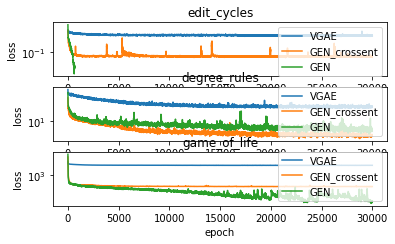

In [9]:
# visualize learning curves
import matplotlib.pyplot as plt
smoothing_steps = 10
fig, axes = plt.subplots(ncols=1, nrows=len(datasets))
for d in range(len(datasets)):
    for k in range(len(models)):
        curves_file  = 'results/%s_%s_learning_curves.csv' % (datasets[d], models[k])
        learning_curves = np.loadtxt(curves_file, delimiter = '\t')
        acum = np.cumsum(np.nanmean(learning_curves, 1))
        axes[d].semilogy((acum[smoothing_steps:] - acum[:-smoothing_steps])/smoothing_steps)
    axes[d].set_xlabel('epoch')
    axes[d].set_ylabel('loss')
    axes[d].set_title(datasets[d])
    axes[d].legend(models)
plt.show()